 # DATA CLEANING

## 0. Set up

### Setting up the environment

In [1]:
#Pour que python reconnaisse un dossier comme un module il faut ajouter en son sein un chicchier __init__.py 
#et également l'ajouter au PATH
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import sys
sys.path.insert(0, "/home/apprenant/Documents/simplon_dev/pyhon_sql/american-dream")


#On peut ensuite importer le dossier comme un module

from src.d00_utils.sqlite_utils import db_connect, save_to_database

In [2]:
# Connection with BDD version 1 (raw data lives there).

con = db_connect('../Data/01_raw/american_dream_v1.db')
cur = con.cursor()
cur.execute('pragma encoding=UTF8')

# 1. Reading the csv (from kaggle) file

In [3]:
query_dfk = """
    SELECT * FROM dataset_kaggle
"""
dfk = pd.read_sql(query_dfk,con=con)

# 2. Exploring Kaggle dataset

In [4]:
print(dfk.shape)
# We print the first five rows to analyse our dataset
dfk.head()

(2253, 16)


,id,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors,easy_apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


Our dataset contains **2253** rows and **16** columns

In [5]:
"""
    We print out all the column's name to see which ones we can remove and which ones we can keep.
    We can notice that some of columns are not necessary for our analysis.
"""
dfk.columns

Index(['id', 'job_title', 'salary_estimate', 'job_description', 'rating',
       'company_name', 'location', 'headquarters', 'size', 'founded',
       'type_of_ownership', 'industry', 'sector', 'revenue', 'competitors',
       'easy_apply'],
      dtype='object')

In [6]:
# I keep only the columns i need
dfk = dfk.drop([
    'job_description', 
    'rating', 
    'headquarters', 
    'size', 
    'founded', 
    'type_of_ownership', 
    'industry', 
    'sector', 
    'revenue', 
    'competitors', 
    'easy_apply'
],axis=1)

# 3. Checking for missing values

In [7]:
print(dfk.isnull().sum())
print(dfk.shape)

id                 0
job_title          0
salary_estimate    0
company_name       1
location           0
dtype: int64
(2253, 5)


We notice there are almost no missing value in this dataset. Only one to be exact which is a missing company name. We could just delete the row with that missing value. It won't change our analysis at all. 

In [8]:
dfk = dfk.dropna()
print(dfk.shape)

(2252, 5)


# 4. Data type processing

In [9]:
print(dfk.dtypes)
dfk.head()

id                  int64
job_title          object
salary_estimate    object
company_name       object
location           object
dtype: object


,id,job_title,salary_estimate,company_name,location
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Vera Institute of Justice\n3.2,"New York, NY"
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Visiting Nurse Service of New York\n3.8,"New York, NY"
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),Squarespace\n3.4,"New York, NY"
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Celerity\n4.1,"New York, NY"
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),FanDuel\n3.9,"New York, NY"


There is one major problem with our data types here. Our main goal is to analyse the salary based on the salary_estimate columns. However, that column is an object data type, we can't performe any aggregate function on it. We have to transform this data into an exploitable data(int in our case). 

In [10]:
#Lambda function to remove the (Glassdoor est.) from the row
estimate = dfk["salary_estimate"].apply(lambda x: x.split("(")[0])
#Takes out the dollar sign and k off of the numbers
estimate = estimate.replace({"\$" : "","K" : ""},regex = True)

Now that we have transformed our salary_estimate column into a nicer way for data analysis, we still need to split the data into two new columns. One that will hold the min estimation and one with the max.

In [11]:
dfk['min_salary'] = estimate.apply(lambda x: x.split("-")[0])
dfk['max_salary'] = estimate.apply(lambda x: x.split("-")[1])

dfk['min_salary'] = pd.to_numeric(dfk['min_salary'])
dfk['max_salary'] = pd.to_numeric(dfk['max_salary'])

dfk['min_salary'] = dfk['min_salary'].apply(lambda x: x * 1000)
dfk['max_salary'] = dfk['max_salary'].apply(lambda x: x * 1000)

dfk.head()

,id,job_title,salary_estimate,company_name,location,min_salary,max_salary
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Vera Institute of Justice\n3.2,"New York, NY",37000.0,66000
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Visiting Nurse Service of New York\n3.8,"New York, NY",37000.0,66000
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),Squarespace\n3.4,"New York, NY",37000.0,66000
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Celerity\n4.1,"New York, NY",37000.0,66000
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),FanDuel\n3.9,"New York, NY",37000.0,66000


The company_name column needs some reworks aswell, we can remove the new line (\n) and the rating.

In [12]:
dfk['company_name'] = dfk['company_name'].apply(lambda x: x.split("\n")[0])
dfk.head()

,id,job_title,salary_estimate,company_name,location,min_salary,max_salary
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Vera Institute of Justice,"New York, NY",37000.0,66000
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Visiting Nurse Service of New York,"New York, NY",37000.0,66000
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),Squarespace,"New York, NY",37000.0,66000
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Celerity,"New York, NY",37000.0,66000
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),FanDuel,"New York, NY",37000.0,66000


We also could separate the state and the city name from the location column if we want to satisfy the first normal law.

In [13]:
states = dfk['location'].apply(lambda x: x.split(", ")[1])
dfk['location'] = dfk['location'].apply(lambda x: x.split(",")[0])

dfk['state'] = states.apply(lambda x: "CO" if "Arapahoe" in x else x)
dfk['state'].value_counts().sum() # return 2252
dfk.head()

,id,job_title,salary_estimate,company_name,location,min_salary,max_salary,state
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Vera Institute of Justice,New York,37000.0,66000,NY
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Visiting Nurse Service of New York,New York,37000.0,66000,NY
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),Squarespace,New York,37000.0,66000,NY
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Celerity,New York,37000.0,66000,NY
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),FanDuel,New York,37000.0,66000,NY


# 5. Outliers check

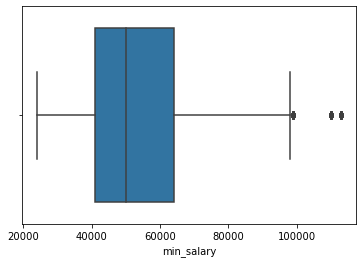

In [14]:
min_salary_boxplt = sns.boxplot(x=dfk["min_salary"])

In [15]:
dfk['min_salary'].describe()

count      2251.000000
mean      54267.436695
std       19579.706082
min       24000.000000
25%       41000.000000
50%       50000.000000
75%       64000.000000
max      113000.000000
Name: min_salary, dtype: float64

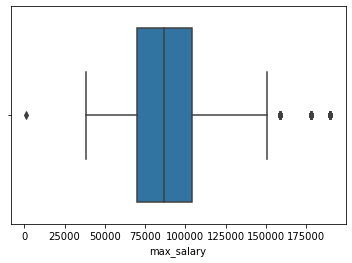

In [16]:
max_salary_boxplt = sns.boxplot(x=dfk["max_salary"])

We can identify severals outliers for both min and max salary. We can't really consider them as real outstanding values. They seems pretty correct. There's an execption for the max_salary where there's a value at 0 which is an incorrect value. We have to remove it.

In [17]:
dfk = dfk[dfk['max_salary'] > 25000]
dfk['max_salary'].describe()

count      2251.000000
mean      89975.122168
std       29321.502211
min       38000.000000
25%       70000.000000
50%       87000.000000
75%      104000.000000
max      190000.000000
Name: max_salary, dtype: float64

Now that we took care of the ouliers in both min and max columns, we can add a mean_salary column in our dataset.

In [18]:
dfk['mean_salary'] = (dfk['min_salary'] + dfk['max_salary'] )/ 2
dfk.head()

,id,job_title,salary_estimate,company_name,location,min_salary,max_salary,state,mean_salary
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Vera Institute of Justice,New York,37000.0,66000,NY,51500.0
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Visiting Nurse Service of New York,New York,37000.0,66000,NY,51500.0
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),Squarespace,New York,37000.0,66000,NY,51500.0
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Celerity,New York,37000.0,66000,NY,51500.0
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),FanDuel,New York,37000.0,66000,NY,51500.0


Our dataset is clean we can finally store it in a new database.

In [19]:
save_to_database('../Data/02_intermediate/american_dream_v2.db','dataset_kaggle',dfk,True)

Help on function save_to_database in module src.d00_utils.sqlite_utils:

save_to_database(db_name, table_name, df_name, is_index)

